# IMPORTANT: SINCE DOING TRAINING IN LOCAL CPU REALLY TAKES LONG TIME AND TIRE MY MACHINE, I USED COLAB. THATS WHY I USE THE FILE PATHS OF MY DRIVE. IF YOU ARE GOING TO TRY IT ON LOCAL COMPUTER PLEASE JUST SIMPLY CHANGE "dataset_dir" VARIABLE

## ABDULLAH ATAHAN TÜRK
## 21827943

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Below here, I read datasets, do the steps, train the models and plot the graph

In [2]:
import torch
from torchvision.models import vgg16, VGG16_Weights
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os

#Firs I read datasets and adjusted cuda. I did all my homework in Colab, so thanks to colab I used GPU.
dataset_dir = "/content/drive/MyDrive"
train_dir = dataset_dir + "/train"
valid_dir = dataset_dir + "/valid"
test_dir = dataset_dir + "/test"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Here is a simple function to transform train and valid datasets.
def load_data(data_dir, transform):
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    return dataset


train_dataset = load_data(train_dir, data_transform)
valid_dataset = load_data(valid_dir, data_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# I choosed and initialized models for training. Then I deleted their last layers.
resnet = resnet50(pretrained=True)
vg16 = vgg16(pretrained=True)
vg16.classifier = None
resnet.fc = None
# Freezed layers
for param in vg16.parameters():
    param.requires_grad = False

for param in resnet.parameters():
    param.requires_grad = False

#Added traineble last layers according to Binary Classification.
resnet.fc = nn.Sequential(
    nn.Linear(2048, 1),
    nn.Sigmoid()
)
resnet = resnet.to(device)

vg16.classifier = torch.nn.Sequential(
    torch.nn.Linear(25088, 4096),
    torch.nn.ReLU(True),
    torch.nn.Dropout(),
    torch.nn.Linear(4096, 4096),
    torch.nn.ReLU(True),
    torch.nn.Dropout(),
    torch.nn.Linear(4096, 1),
    nn.Sigmoid()
)
vg16 = vg16.to(device)

train_accs_vgg16 = []
valid_accs_vgg16 = []
train_accs_resnet = []
valid_accs_resnet = []
# Here is my function for training
def train_model(dataloader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = torch.where(labels == 0, 1, 0)
        labels = labels.unsqueeze(1).float().to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        # I take threshold as 0.4 because most of the images were 0, and it causes imbalance. With choosing threshold low,
        # I get some more balanced training. I did the same thing in the validation function too.
        preds = (outputs > 0.4).float()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total += labels.size(0)
    # Calculated train losses and accuracies.
    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total

    return epoch_loss, epoch_acc
# Here is my validation function.
def validate_model(dataloader, model, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            # Below, I converted classes to 0 and 1. I did the same thing in the validation too.
            labels = torch.where(labels == 0, 1, 0)
            labels = labels.unsqueeze(1).float().to(device)

            outputs = model(inputs)
            preds = (outputs > 0.4).float()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total

    return epoch_loss, epoch_acc
# Since we are doing Binary Classification, I used BCELoss. For optimizer, according to my researches using Adam is the best.
num_epochs = 10
criterion = torch.nn.BCELoss()
optimizer_resnet = torch.optim.Adam(resnet.fc.parameters(), lr=0.0001)
optimizer_vgg16 = torch.optim.Adam(vg16.classifier.parameters(), lr=0.0001)
# Here is the training and validation parts with 10 epochs.
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)
    
    train_lossvgg, train_accvgg = train_model(train_loader, vg16, criterion, optimizer_vgg16, device)
    valid_lossvgg, valid_accvgg = validate_model(valid_loader, vg16, criterion, device)

    train_accs_vgg16.append(train_accvgg)
    valid_accs_vgg16.append(valid_accvgg)

    print(f'Training VGG16: Loss: {train_lossvgg:.4f} Acc: {train_accvgg:.4f}')
    print(f'Validation VGG16: Loss: {valid_lossvgg:.4f} Acc: {valid_accvgg:.4f}')
    # I saved weights to use them later in the testing.
    torch.save({
        'epoch': epoch,
        'model_state_dict': vg16.state_dict(),
        'optimizer_state_dict': optimizer_vgg16.state_dict(),
        'loss': train_lossvgg,
    }, f"/content/drive/MyDrive/vgg16_epoch_{epoch+1}_new.pt")

    train_loss, train_acc = train_model(train_loader, resnet, criterion, optimizer_resnet, device)
    valid_loss, valid_acc = validate_model(valid_loader, resnet, criterion, device)
    train_accs_resnet.append(train_acc)
    valid_accs_resnet.append(valid_acc)

    print(f'Training ResNet50: Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
    print(f'Validation ResNet50: Loss: {valid_loss:.4f} Acc: {valid_acc:.4f}')

    torch.save({
        'epoch': epoch,
        'model_state_dict': resnet.state_dict(),
        'optimizer_state_dict': optimizer_resnet.state_dict(),
        'loss': train_loss,
    }, f"/content/drive/MyDrive/resnet_epoch_{epoch+1}_new.pt")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 137MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

Epoch 1/10
----------
Training VGG16: Loss: 0.4762 Acc: 0.7840
Validation VGG16: Loss: 0.4812 Acc: 0.8000
Training ResNet50: Loss: 0.5012 Acc: 0.7610
Validation ResNet50: Loss: 0.4992 Acc: 0.8000
Epoch 2/10
----------
Training VGG16: Loss: 0.3415 Acc: 0.8435
Validation VGG16: Loss: 0.5284 Acc: 0.7533
Training ResNet50: Loss: 0.4744 Acc: 0.8130
Validation ResNet50: Loss: 0.4920 Acc: 0.8000
Epoch 3/10
----------
Training VGG16: Loss: 0.2329 Acc: 0.8940
Validation VGG16: Loss: 0.7332 Acc: 0.7800
Training ResNet50: Loss: 0.4649 Acc: 0.8130
Validation ResNet50: Loss: 0.4822 Acc: 0.8000
Epoch 4/10
----------
Training VGG16: Loss: 0.1189 Acc: 0.9545
Validation VGG16: Loss: 1.1291 Acc: 0.7867
Training ResNet50: Loss: 0.4557 Acc: 0.8150
Validation ResNet50: Loss: 0.4676 Acc: 0.8000
Epoch 5/10
----------
Training VGG16: Loss: 0.0728 Acc: 0.9775
Validation VGG16: Loss: 1.1176 Acc: 0.7267
Training ResNet50: Loss: 0.4485 Acc: 0.8130
Validation ResNet50: Loss: 0.4616 Acc: 0.8000
Epoch 6/10
---------

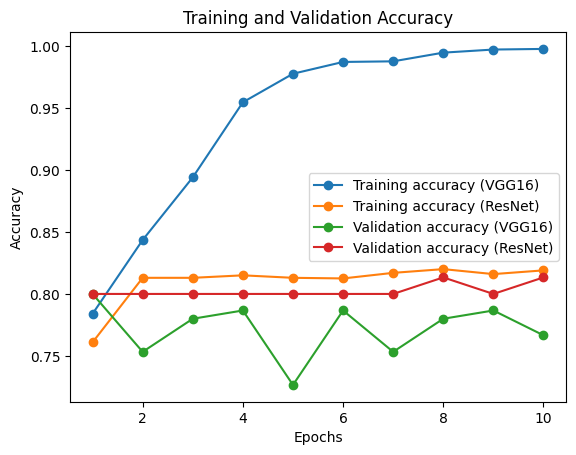

In [11]:
# Since the lists are on the GPU, I need to move them to CPU to plot them to graph. So in here, I moved my accuracy
# lists to CPU.
train_accs_resnet_cpu = [t.cpu().item() for t in train_accs_resnet]
valid_accs_resnet_cpu = [t.cpu().item() for t in valid_accs_resnet]
train_accs_vgg16_cpu = [t.cpu().item() for t in train_accs_vgg16]
valid_accs_vgg16_cpu = [t.cpu().item() for t in valid_accs_vgg16]

epoch_number = range(1, 11)

# Plot training accuracy for both models
plt.plot(epoch_number, train_accs_vgg16_cpu, label='Training accuracy (VGG16)', marker='o')
plt.plot(epoch_number, train_accs_resnet_cpu, label='Training accuracy (ResNet)', marker='o')

# Plot validation accuracy for both models
plt.plot(epoch_number, valid_accs_vgg16_cpu, label='Validation accuracy (VGG16)', marker='o')
plt.plot(epoch_number, valid_accs_resnet_cpu, label='Validation accuracy (ResNet)', marker='o')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.show()


Above here, we can see our graph. As expected, training accuracy of VGG16 increase all the time and get really well at the end. But training accuracy of Resnet not improved well. Their validation accuracies are not improved, even sometimes they decreased. I think one of the reason was imbalanced data, but I think I did something a little wrong too but I coulnd't find my mistake. Still, I think my results are not bad even they are not the best.

In [25]:
from PIL import Image
import csv

# Now load the state dict

state_dict_vgg16 = torch.load('/content/drive/MyDrive/vgg16_epoch_9_new.pt')
vg16.load_state_dict(state_dict_vgg16['model_state_dict'])
vg16.eval()  # Set the model to evaluation mode

# Loop over all images in the 'test' directory
with open('predictions_vgg16.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Id", "Label"])  # Write header

    for filename in os.listdir(test_dir):
        
        img = Image.open(os.path.join(test_dir, filename))

        # Apply transformations
        img_t = data_transform(img)

        # Unsqueeze dimensions to simulate a batch
        img_u = img_t.unsqueeze(0).to(device)

        # Get predictions
        with torch.no_grad():
            out = vg16(img_u)

        # Here i choose threshold as 0.2 because in the train dataset, only 1/5 of the images were 1 and rest of them was 0.
        preds = (out > 0.2).int()


        writer.writerow([filename, preds.item()])

print("Labeling is done")

Labeling is done


In [26]:
state_dict_resnet50= torch.load('/content/drive/MyDrive/resnet_epoch_9_new.pt')
resnet.load_state_dict(state_dict_resnet50['model_state_dict'])
resnet.eval()  # Set the model to evaluation mode

# Loop over all images in the 'test' directory
with open('predictions_resnet.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Id", "Label"])  # Write header

    for filename in os.listdir(test_dir):

        img = Image.open(os.path.join(test_dir, filename))

        # Apply transformations
        img_t = data_transform(img)

        # Unsqueeze dimensions to simulate a batch
        img_u = img_t.unsqueeze(0).to(device)

        # Get predictions
        with torch.no_grad():
            out = vg16(img_u)

        # Here i choose threshold as 0.2 because in the train dataset, only 1/5 of the images were 1 and rest of them was 0.
        preds = (out > 0.2).int()


        writer.writerow([filename, preds.item()])

print("Labeling is done")

Labeling is done


So for improving my model, I decreased the learning rate and adjusted the threshold value to 0.4 in training and validation and to 0.2 in testing. With these thresholds I got better results. Because nearly %80 of the images belong to benign tumors. So for a imbalanced dataset, adjusting the threshold according to that balance is a good thing to improve the accuracy score.